# Goals and methods
In this notebook, we will be using 'Segmentation_models.pytorch' to setup the different neural network architectures and experiment with different parameters. We will be using 'Albumentations' for data augmentation, given we have a pretty small dataset to work with. The whole implementation is based on pytorch, so that will be the 'glue' in our project, to put it all together

# 1. Imports

In [1]:
# Data tools
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import json

# Data visualization
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Data loading and manipulation
from torch.utils.data import DataLoader
from packages.dataset import Dataset
import albumentations as albu
from packages.helpers import *

# Machine Learning model and training
import torch
import segmentation_models_pytorch as smp



def run():
    torch.multiprocessing.freeze_support()

if __name__ == '__main__':
    run()

import gc

gc.collect()

torch.cuda.empty_cache()

%load_ext autoreload
%autoreload 2

# 2. Global constants

In [2]:
IMAGE_DIR = 'data/images'
MASKS_DIR = 'data/masks'
DATA_DIR = 'data'


PANELS, BACKGROUND = 0, 1


MASK_VALUE = BACKGROUND

# 3. Loading dataset

### 3.1. Directories

In [3]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

### 3.2. Visualization

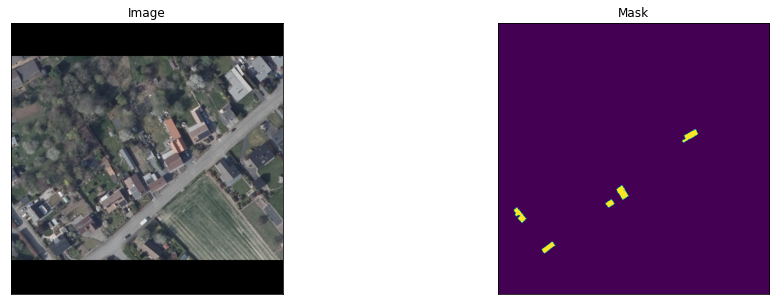

In [4]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['solar panel'], mask_value=MASK_VALUE)

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    mask=mask.squeeze(),
)

# 4. Augmentations
As we have a small dataset, we want to increase the amount of data and prevent model overfitting. 
For this task, we will apply a large number of different augmentations :
* horizontal flip
* affine transforms
* perspective transforms
* brightness/contrast/colors manipulations
* image bluring and sharpening
* gaussian noise
* random crops

To do so, we will use the library called 'Albumentations'.

### 4.1. Visualization of augmented results

C:\Users\wengl\AppData\Roaming\Python\Python38\site-packages\albumentations\augmentations\transforms.py:1822: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


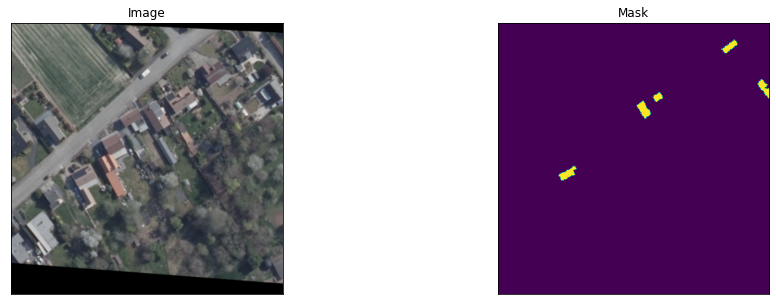

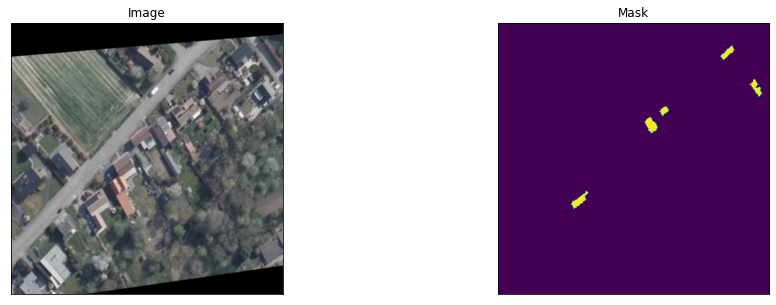

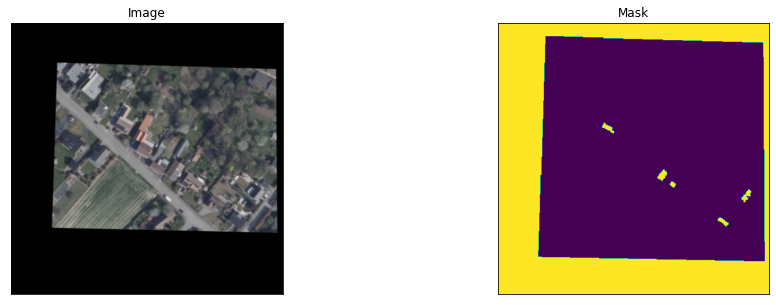

In [5]:

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['solar panel'],
    mask_value=MASK_VALUE
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[5]
    visualize(image=image, mask=mask.squeeze(-1))

# 5. Setting up training environment

### 5.1. Global parameters

In [6]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['solar panel']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'



preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

### 5.2. Data preparation

In [7]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(mask_value=MASK_VALUE), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    mask_value=MASK_VALUE
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(mask_value=MASK_VALUE), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    mask_value=MASK_VALUE
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

### 5.3. Loss and metrics

In [8]:
# Loss
loss = smp.losses.SoftBCEWithLogitsLoss()
loss.__name__ = "SoftBCEWithLogitsLoss"

# Metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(),
    smp.utils.metrics.Accuracy(),
    smp.utils.metrics.Recall(),
    smp.utils.metrics.Precision(),
]

# 6. Unet

### 6.1. Setting up model

In [9]:
# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

# Optimization
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

### 6.2. Training

#### 6.4.1. Creating epoch runners

In [10]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

##### 6.4.2. Training the model for 100 epochs

In [11]:
# Train model for 100 epochs

max_score = 0
train_logs = []
valid_logs = []

max_epochs = 200
epochs = 100

for i in range(0, max_epochs):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
   

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, f'./best_model_unet_{MASK_VALUE}_{epochs}.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

    if i % 100 == 99:
        print("100 epochs trained, dumping logs...")
        with open(f'train_logs_unet_{MASK_VALUE}_{epochs}.json', "w") as write_file:
            json.dump(train_logs, write_file)

        with open(f'valid_logs_unet_{MASK_VALUE}_{epochs}.json', "w") as write_file:
            json.dump(valid_logs, write_file)
      
        epochs += 100



Epoch: 0
valid: 100%|██████████| 26/26 [00:02<00:00, 12.61it/s, SoftBCEWithLogitsLoss - 0.8415, iou_score - 0.005928, fscore - 0.01158, accuracy - 0.9343, recall - 0.08824, precision - 0.006933] 
Model saved!

Epoch: 1
valid: 100%|██████████| 26/26 [00:02<00:00, 12.84it/s, SoftBCEWithLogitsLoss - 0.8116, iou_score - 0.0009371, fscore - 0.001847, accuracy - 0.9939, recall - 0.005085, precision - 0.005206]   

Epoch: 2
valid: 100%|██████████| 26/26 [00:02<00:00, 12.76it/s, SoftBCEWithLogitsLoss - 0.7848, iou_score - 0.002351, fscore - 0.004495, accuracy - 0.9951, recall - 0.002624, precision - 0.02109]     

Epoch: 3
valid: 100%|██████████| 26/26 [00:01<00:00, 13.04it/s, SoftBCEWithLogitsLoss - 0.7706, iou_score - 0.0003452, fscore - 0.0006842, accuracy - 0.9953, recall - 0.0004342, precision - 0.001612]

Epoch: 4
valid: 100%|██████████| 26/26 [00:02<00:00, 12.76it/s, SoftBCEWithLogitsLoss - 0.7567, iou_score - 3.131e-10, fscore - 3.131e-10, accuracy - 0.9953, recall - 3.135e-10, precis

KeyboardInterrupt: 

In [ ]:
#!jupyter nbconvert --to script Training.ipynb

In [ ]:
with open("train_logs_unet_{MASK_VALUE}.json", "w") as write_file:
    json.dump(train_logs, write_file)

In [ ]:
with open("valid_logs_unet_{MASK_VALUE}.json", "w") as write_file:
    json.dump(valid_logs, write_file)

# 7. DeepLabV3

In [ ]:
#gc.collect()

#torch.cuda.empty_cache()

### 7.1. Setting up model

In [ ]:
# create segmentation model with pretrained encoder
model = smp.DeepLabV3(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

# Optimization
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

### 7.2. Training

#### 7.2.1. Creating epoch runners

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

##### 7.2.2. Training the model for 100 epochs

In [ ]:
# Train model for 100 epochs

max_score = 0
train_logs = []
valid_logs = []

for i in range(0, 100):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model_deeplab.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

In [ ]:
with open("train_logs_deeplab.json", "w") as write_file:
    json.dump(train_logs, write_file)

In [ ]:
with open("valid_logs_deeplab.json", "w") as write_file:
    json.dump(train_logs, write_file)

In [ ]:
#!jupyter nbconvert --to script Training.ipynb